# Introduction

Another way to think about the bike sharing network data set is to treat the network of bikes and its rental patterns as a kind of _sensor_ that can pick up information about what's going on in the city and its population. 

In our case we don't have much information about the goings-on, but we can demonstrate the idea by trying to predict the temperature from the non-weather information in the bike sharing data set and see if the number of bikes rented is important for such a prediction.

# Get the data

In [46]:
from pycaret.datasets import get_data

In [47]:
df = get_data('bike')

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1/1/2011,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2,1/1/2011,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,3,1/1/2011,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,4,1/1/2011,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,5,1/1/2011,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  cnt         17379 non-null  int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 2.0+ MB


Here's a description of the features, copied from https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset. 

```
- instant: record index
- dteday : date
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered 
```

# Prepare data

We use PyCaret to automatically prepare the data for us (using the default settings of the `setup` function):

In [49]:
from pycaret.regression import *

In [51]:
ignore_features = ['instant', 'weathersit', 'atemp', 'hum', 'windspeed']

In [53]:
clf = setup(df, target = 'temp', ignore_features=ignore_features)

,Description,Value
0,session_id,7467
1,Target,temp
2,Original Data,"(17379, 15)"
3,Missing Values,False
4,Numeric Features,2
5,Categorical Features,6
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(12165, 30)"


# Modelling

Let's find the top performing models from those in PyCaret:

In [56]:
top3 = compare_models(n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0506,0.0042,0.0651,0.8856,0.0450,0.1412,0.5730
xgboost,Extreme Gradient Boosting,0.0519,0.0045,0.0669,0.8791,0.0462,0.1447,0.1340
lightgbm,Light Gradient Boosting Machine,0.0533,0.0046,0.0677,0.8763,0.0468,0.1486,0.0540
rf,Random Forest Regressor,0.0549,0.0052,0.0720,0.8602,0.0498,0.1535,0.1300
gbr,Gradient Boosting Regressor,0.0603,0.0058,0.0762,0.8434,0.0528,0.1700,0.0810
et,Extra Trees Regressor,0.0584,0.0063,0.0791,0.8313,0.0545,0.1617,0.1370
lr,Linear Regression,0.0687,0.0075,0.0867,0.7971,0.0597,0.1911,0.0150
ridge,Ridge Regression,0.0687,0.0075,0.0867,0.7971,0.0597,0.1912,0.0140
br,Bayesian Ridge,0.0687,0.0075,0.0867,0.7971,0.0597,0.1912,0.0170
dt,Decision Tree Regressor,0.0678,0.0087,0.0932,0.7658,0.0644,0.1861,0.0180


Here's a VotingRegressor ensemble: 

In [57]:
blender = blend_models(estimator_list = top3)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0511,0.0043,0.0655,0.8779,0.0453,0.1608
1,0.0509,0.0043,0.0656,0.8834,0.0455,0.1381
2,0.0504,0.0041,0.0643,0.8844,0.0443,0.1312
3,0.0524,0.0044,0.0664,0.8777,0.0457,0.1581
4,0.0527,0.0045,0.0668,0.8822,0.0460,0.1382
5,0.0501,0.0042,0.0650,0.8848,0.0449,0.1353
6,0.0514,0.0044,0.0664,0.8878,0.0457,0.1364
7,0.0516,0.0044,0.0663,0.8834,0.0460,0.1383
8,0.0503,0.0041,0.0638,0.8904,0.0438,0.1331
9,0.0499,0.0043,0.0653,0.8891,0.0455,0.1577


...and a stacking ensemble:

In [58]:
stacked = stack_models(estimator_list = top3)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0500,0.0042,0.0648,0.8804,0.0448,0.1584
1,0.0500,0.0042,0.0648,0.8861,0.0449,0.1346
2,0.0495,0.0040,0.0634,0.8877,0.0437,0.1282
3,0.0519,0.0044,0.0660,0.8792,0.0454,0.1567
4,0.0518,0.0043,0.0659,0.8852,0.0455,0.1353
5,0.0502,0.0042,0.0650,0.8848,0.0449,0.1351
6,0.0511,0.0044,0.0661,0.8888,0.0455,0.1355
7,0.0512,0.0044,0.0662,0.8840,0.0459,0.1370
8,0.0498,0.0040,0.0631,0.8927,0.0433,0.1306
9,0.0491,0.0042,0.0647,0.8910,0.0452,0.1549


Let's pick out the best model (or combination of models) we found above:

In [59]:
best = automl()

In [60]:
best

StackingRegressor(cv=KFold(n_splits=10, random_state=RandomState(MT19937) at 0x1935A494640,
   shuffle=False),
                  estimators=[('catboost',
                               <catboost.core.CatBoostRegressor object at 0x000001935A3CBF40>),
                              ('xgboost',
                               XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            enable_categorical=False, gamma=0,
                                            gpu_id=-1, impor...
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=100, n_jobs=-1,
                   

# Evaluate models

Let's compute predictions and scores on the test data using the best model found above:

In [61]:
preds = predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,0.0493,0.0040,0.0629,0.8930,0.0434,0.1321


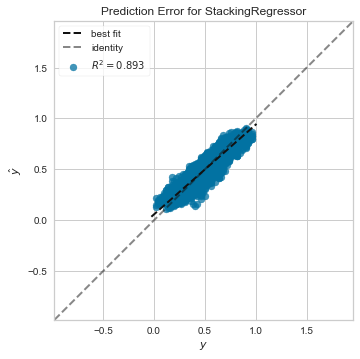

In [63]:
plot_model(best, 'error')

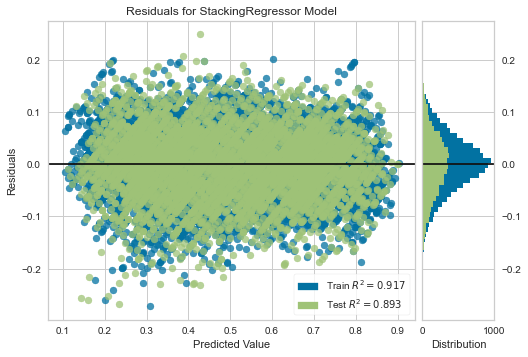

In [62]:
plot_model(best)

In [64]:
from sklearn.inspection import permutation_importance

In [65]:
X_test = get_config(variable='X_test')
y_test = get_config(variable='y_test')

In [66]:
r = permutation_importance(best, X_test, y_test)

Here's the ranked list:

In [67]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_test.columns[i]:<8}"
        f"{r.importances_mean[i]:.3f}"
        f" +/- {r.importances_std[i]:.3f}")

season_30.522 +/- 0.007
cnt     0.161 +/- 0.003
hr      0.098 +/- 0.003
season_10.072 +/- 0.001
season_20.068 +/- 0.001
dteday_month_90.068 +/- 0.003
dteday_month_60.051 +/- 0.002
yr_1    0.048 +/- 0.001
dteday_month_30.035 +/- 0.002
mnth_5  0.022 +/- 0.001
dteday_month_100.022 +/- 0.001
mnth_12 0.016 +/- 0.001
workingday_00.015 +/- 0.001
season_40.012 +/- 0.001
mnth_11 0.012 +/- 0.000
mnth_1  0.010 +/- 0.001
mnth_4  0.009 +/- 0.000
dteday_weekday_00.009 +/- 0.000
dteday_is_month_start_00.008 +/- 0.001
dteday_is_month_end_10.008 +/- 0.000
dteday_weekday_10.006 +/- 0.001
dteday_month_70.006 +/- 0.000
holiday_10.005 +/- 0.000
weekday_50.005 +/- 0.000
dteday_month_20.004 +/- 0.000
dteday_weekday_20.003 +/- 0.000
dteday_weekday_50.003 +/- 0.000
dteday_weekday_30.002 +/- 0.000
dteday_weekday_60.002 +/- 0.000
dteday_month_80.000 +/- 0.000
